In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Dataset Overview

In this section, we load the dataset, check its basic structure, and analyze the distribution of the target variable `Review_Score`.
We also explore a few example rows to understand the kind of data we are working with.


In [ ]:
path = "https://frasca.di.unimi.it/MLDNN/input_data.csv"

df = pd.read_csv(path)

# decrease the size of dataset for fast training
df = df.sample(frac=0.03, random_state=42).reset_index(drop=True)
df = df.drop(["Average_Score"], axis=1)

print("Dataset shape:", df.shape)
df.head(3)

Dataset shape: (413, 9)


,Hotel_Address,Review_Date,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,104 104 Bayswater Rd Westminster Borough Londo...,4/27/2017,Thistle Kensington Gardens,Ireland,2134,1,7.1,Bigger reception area Did not take breakfast ...,Good_review
1,55 55 61 Westbourne Terrace Westminster Boroug...,6/11/2016,Shaftesbury Premier London Paddington,Australia,3609,8,6.3,No face washers and poor quality towels,Bad_review
2,350 350 Oxford Street Westminster Borough Lond...,1/9/2016,Radisson Blu Edwardian Berkshire,Switzerland,1600,1,5.8,Very small room Nice stag,Bad_review


In [ ]:
# Missing values
print("Missing values per column:\n")
print(df.isnull().sum())

Missing values per column:

Hotel_Address              0
Review_Date                0
Hotel_Name                 0
Reviewer_Nationality       0
Hotel_number_reviews       0
Reviewer_number_reviews    0
Review_Score               0
Review                     0
Review_Type                0
dtype: int64


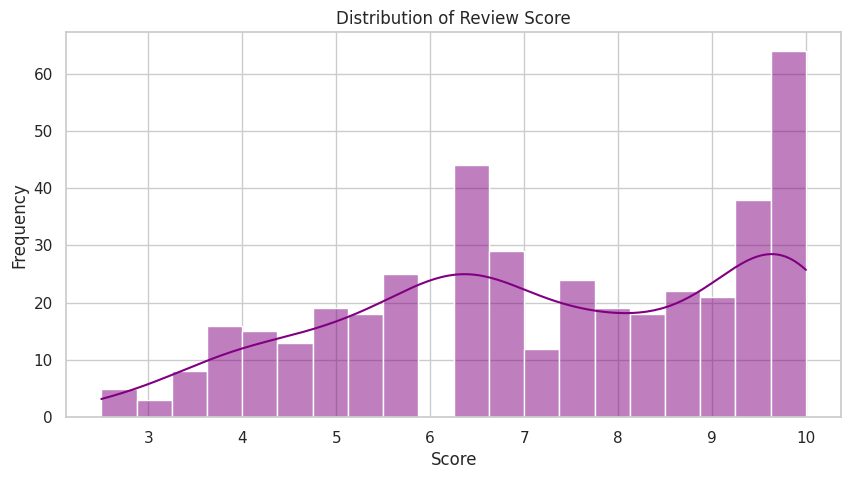

In [ ]:
# Distribution of Review Score (target for regression)
plt.figure(figsize=(10, 5))
sns.histplot(df['Review_Score'], bins=20, kde=True, color="purple")
plt.title("Distribution of Review Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df['Review_Score'].describe()

,Review_Score
count,413.000000
mean,7.254964
std,2.109043
min,2.500000
25%,5.800000
50%,7.100000
75%,9.200000
max,10.000000


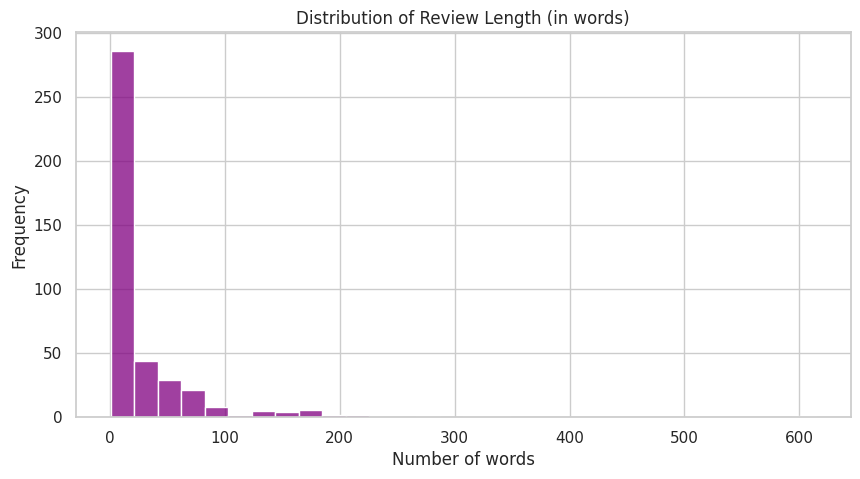

In [ ]:
df['review_length'] = df['Review'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=30, color='purple')
plt.title("Distribution of Review Length (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

## 2. Data Preprocessing

To effectively prepare the dataset for model training, I modularized the preprocessing steps into separate functions for numerical, categorical, and text features. This modular design improves code readability, reusability, and maintainability. All steps are later integrated into a single function for streamlined preprocessing.

### 2.1 Dropping Irrelevant or Redundant Columns

**CHANGE** I decided to drop the `Hotel Address` and `Review Date` columns because their data was very sparse and could add noise to the final model.

Before preprocessing, we remove some columns that are either not useful for the regression task or could introduce noise or data leakage.

- `Hotel Address`: too detailed and inconsistent; likely high cardinality with little predictive power.
- `Review Date`: time-based leakage risk and difficult to interpret without seasonality context.
- `Review Type`: this is used for classification; we are solving only the regression task.

In [ ]:
df = df.drop(columns=[
    'Hotel_Address',
    'Review_Date',
    'Review_Type'
])

In [ ]:
num_cols = ['Hotel_number_reviews', 'Reviewer_number_reviews']
cat_cols = ['Hotel_Name', 'Reviewer_Nationality']

### 2.1 Numerical Features Preprocessing

**CHANGE** One detail I forgot to mention in the proposed solution is that the numerical features should be normalized prior to concatenation with the other inputs, and only then passed through the final head network (FC → ReLU → FC).

In this part, we normalize the numerical features using `StandardScaler`. This transformation is important to make sure the model treats each numeric input on a comparable scale.

In [ ]:
from sklearn.preprocessing import StandardScaler

def numerical_preprocessing(df, columns):
    """
    Normalize numeric features using StandardScaler.
    """
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[columns])
    return scaled, scaler

### 2.2 Categorical Features Preprocessing

The function `categorical_preprocessing` converts each categorical column into integer indices using `LabelEncoder`. These integer representations can later be passed through embedding layers in the model.

In [ ]:
from sklearn.preprocessing import LabelEncoder

def categorical_preprocessing(df, columns):
    """
    Encode categorical features into integer indices.
    """
    encoded = {}
    encoders = {}
    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoded[col] = df[col].values
        encoders[col] = le
    return encoded, encoders

### 2.3 Review text cleaning

**CHANGE** In the proposed solution I forgot to mention that before tokenizing raw text, we must first clean the text data. This step ensures that unnecessary noise—such as punctuation, extra whitespace, and uninformative stopwords—is removed. Cleaning the text improves the quality of the tokenization process, helps reduce vocabulary size, and allows the model to focus on meaningful patterns in the data.


To improve the quality of textual input for the model, a custom `clean_text` function is used. It performs the following steps:

- **Lowercasing**: Converts all characters to lowercase for uniformity.
- **Punctuation removal**: Removes punctuation marks to reduce noise.
- **Whitespace normalization**: Replaces multiple whitespace characters with a single space.
- **Stopword removal**: Removes common English stopwords while preserving important negation words (e.g., "not", "no", "never").
- **Lemmatization**: Reduces words to their base forms using WordNet lemmatizer.

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
words_to_keep = {
    'not', 'no', 'nor', 'don', 'ain', 'aren', 'couldn', 'didn', 'doesn',
    'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn',
    'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'never', 'aren'
}
stop_words = stop_words - words_to_keep

lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text, remove_stopwords=True, lemmatize=True):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()

    if remove_stopwords:
        tokens = [word for word in words if word not in stop_words]
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

### 2.4 Unified Preprocessing Function

All preprocessing steps are combined in the `preprocess_data` function:

- **Numerical features** are scaled using `StandardScaler`.
- **Categorical features** are encoded with `LabelEncoder`.
- **Text reviews** are cleaned, tokenized, and padded.
- **Target (`Review_Score`)** is normalized. **CHAGE** I decided to normalize the target value because it helps stabilize training and speeds up convergence

The function returns a dictionary with all processed inputs and transformers for future use. This approach ensures a clean and consistent data pipeline for model training.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(df, num_cols, cat_cols, max_words=20000, max_len=400, tokenizer=None):
    df = df.copy()

    X_num, scaler = numerical_preprocessing(df, num_cols)     # Numerical preprocessing
    X_cat, encoders = categorical_preprocessing(df, cat_cols) # Categorical preprocessing

    # Text preprocessing
    df['Review'] = df['Review'].astype(str).fillna("").apply(clean_text)
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
        tokenizer.fit_on_texts(df['Review'])

    sequences = tokenizer.texts_to_sequences(df['Review'])
    X_text = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y = df['Review_Score'].values

    return {
        'numeric': X_num,
        'categorical': X_cat,
        'text': X_text,
        'score': y,
        'tokenizer': tokenizer,
        'scaler': scaler,
        'encoders': encoders
    }

In [ ]:
data = preprocess_data(df, num_cols, cat_cols)

### 2.4 GloVe Embeddings Preparation

To incorporate semantic meaning of words, I used pre-trained **GloVe** embeddings. This part includes:

- **`load_glove_embeddings`**: Loads GloVe vectors from a `.txt` file and stores them in a dictionary mapping words to their embedding vectors.
- **`build_embedding_matrix`**: Constructs an embedding matrix where each row corresponds to a word in the tokenizer's vocabulary. Words not found in GloVe are assigned a zero vector.

This matrix is later used to initialize the embedding layer in the model.

In [ ]:
def load_glove_embeddings(glove_file_path, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                continue
    print(f"Loaded {len(embeddings_index):,} word vectors from GloVe")
    return embeddings_index

In [ ]:
def build_embedding_matrix(tokenizer, embeddings_index, embedding_dim=300, max_words=20000):
    word_index = tokenizer.word_index
    num_words = min(max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    return embedding_matrix

In [ ]:
import os

if not os.path.exists("glove.6B.zip"):
    !wget http://nlp.stanford.edu/data/glove.6B.zip

if not os.path.exists("glove.6B.300d.txt"):
    !unzip -q glove.6B.zip

--2025-07-03 16:31:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-03 16:31:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-03 16:31:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_path = 'glove.6B.300d.txt'
# glove_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
embeddings_index = load_glove_embeddings(glove_path)

Loaded 400,000 word vectors from GloVe


In [ ]:
tokenizer = data['tokenizer']
embedding_matrix = build_embedding_matrix(tokenizer, embeddings_index)

Embedding matrix shape: (1853, 300)


## 3. Model Architecture: BiLSTM with Attention

In this section, we build the deep learning model that will predict the `Review Score` based on multiple input types:

- **Textual input** (`Review`): processed with a BiLSTM layer using pre-trained **GloVe 300d** embeddings, followed by an attention mechanism to focus on the most relevant words.
- **Categorical features**: embedded via trainable embedding layers.
- **Numerical features** : normalized and fed as-is into dense layers.

All inputs are concatenated into a shared representation, followed by dense layers, and finally a regression output (a single float value in range `[0, 10]`

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        # inputs: (batch_size, time_steps, hidden_size)
        score = tf.nn.tanh(inputs)
        weights = tf.nn.softmax(score, axis=1)
        context = weights * inputs
        context = tf.reduce_sum(context, axis=1)
        return context

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import Flatten, Concatenate


class BiLSTMWithAttentionModel(tf.keras.Model):
    def __init__(self, embedding_matrix, cat_info, num_numerical_features, hidden_size=32, dropout=0.4):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                   weights=[embedding_matrix], trainable=False)
        self.bilstm = Bidirectional(LSTM(hidden_size, return_sequences=True))
        self.attn = Attention()
        self.flatten = Flatten()

        # custom categorical embeddings
        self.cat_embeddings = {
            name: Embedding(input_dim=n_unique, output_dim=8)
            for name, n_unique in cat_info.items()
        }

        self.head = tf.keras.Sequential([
            Dense(hidden_size, activation='relu'),
            Dropout(dropout),
            Dense(1, activation='linear')
        ])

    def call(self, inputs):
        x_text = self.embedding(inputs['text'])
        x_text = self.bilstm(x_text)
        x_text = self.attn(x_text)
        x_cat = [self.flatten(self.cat_embeddings[name](inputs[name])) for name in self.cat_embeddings]

        x_num = inputs['numeric']

        x = Concatenate()([x_text, x_num] + x_cat)
        return self.head(x)

### 3.1 Train/Test Split and Input Dictionary Preparation

To prepare data for model training and validation, I performed the following steps:

- **Combined features** (`text`, `numeric`, and selected categorical columns) and target `score` into a list.
- **Split** the dataset into training and validation sets using `train_test_split` with 10% of data reserved for validation.
- **Reassembled the split arrays** into dictionaries (`X_train` and `X_val`) expected by the custom Keras model, preserving the original feature names.

This structure ensures that all inputs are passed correctly to the model during training and evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(X_values, y, random_state=42):
    # train (80%) и temp (20%)
    X_train_parts, X_temp_parts, y_train, y_temp = train_test_split(
        list(zip(*X_values)), y, test_size=0.2, random_state=random_state
    )

    # val (10%) и test (10%)
    X_val_parts, X_test_parts, y_val, y_test = train_test_split(
        X_temp_parts, y_temp, test_size=0.5, random_state=random_state
    )

    X_train = list(zip(*X_train_parts))
    X_val = list(zip(*X_val_parts))
    X_test = list(zip(*X_test_parts))

    X_train_dict = {
        'text': np.array(X_train[0]),
        'numeric': np.array(X_train[1]),
        'Hotel_Name': np.array(X_train[2]),
        'Reviewer_Nationality': np.array(X_train[3]),
    }
    X_val_dict = {
        'text': np.array(X_val[0]),
        'numeric': np.array(X_val[1]),
        'Hotel_Name': np.array(X_val[2]),
        'Reviewer_Nationality': np.array(X_val[3]),
    }
    X_test_dict = {
        'text': np.array(X_test[0]),
        'numeric': np.array(X_test[1]),
        'Hotel_Name': np.array(X_test[2]),
        'Reviewer_Nationality': np.array(X_test[3]),
    }

    return X_train_dict, X_val_dict, X_test_dict, y_train, y_val, y_test

In [ ]:
X_values = [
    data['text'],
    data['numeric'],
    data['categorical']['Hotel_Name'],
    data['categorical']['Reviewer_Nationality']
]
y = data['score']

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_values, y)


In [ ]:
cat_info = {
    'Hotel_Name': data['categorical']['Hotel_Name'].max() + 1,
    'Reviewer_Nationality': data['categorical']['Reviewer_Nationality'].max() + 1
}

## 3.2 Model Training

This section covers the initialization, compilation, and training of the model.

- **Model Initialization**  
  The `BiLSTMWithAttentionModel` is created using:
  - A pretrained GloVe embedding matrix for text input
  - Categorical feature information (`cat_info`)
  - The number of numerical features from the dataset
  - A hidden size of 64 and dropout of 0.4 for regularization

- **Early Stopping**  
  Early stopping is used to prevent overfitting by monitoring the validation loss.  
  If the validation loss does not improve for 3 epochs, training stops and the best model weights are restored.

- **Model Compilation**  
  The model is compiled using the Adam optimizer (`learning_rate=1e-3`), with:
  - Mean Squared Error (MSE) as the loss function
  - MSE and R² score as evaluation metrics

- **Model Training**  
  The model is trained on the training set for up to 25 epochs with a batch size of 32.  
  Validation data is used to monitor generalization performance during training.  
  The `early_stop` callback is passed to stop training early if needed.


In [ ]:
model = BiLSTMWithAttentionModel(
    embedding_matrix=embedding_matrix,
    cat_info=cat_info,
    num_numerical_features=data['numeric'].shape[1],
    hidden_size=64,
    dropout=0.4
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.metrics import MeanSquaredError

adam = Adam(learning_rate=3e-4)
score_mse = MeanSquaredError(name='mse')
score_r2_score = R2Score(name='r2_score')

model.compile(
    optimizer=adam,
    loss='mse',
    metrics=[score_r2_score]
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=25,
    callbacks=[early_stop]
)

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 58.4260 - r2_score: -12.0094 - val_loss: 51.4837 - val_r2_score: -9.3610
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 56.4826 - r2_score: -12.1963 - val_loss: 49.1367 - val_r2_score: -8.8887
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 53.3223 - r2_score: -11.5454 - val_loss: 41.9403 - val_r2_score: -7.4404
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 37.0266 - r2_score: -6.4727 - val_loss: 5.9888 - val_r2_score: -0.2052
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.6239 - r2_score: -0.2147 - val_loss: 8.2676 - val_r2_score: -0.6638
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.8070 - r2_score: -0.2783 - val_loss: 5.4101 - val_r2_score: -0.0888
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.9538 - r2_score: -0.0776 - val_loss: 5.2146 - val_r2_score: -0.0494
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.7228 - r2_score: -0.0386

## 5. Results

To track training progress, we plotted both training and validation **loss** (MSE) and **R² score** across epochs.

- **Train loss** steadily decreased, indicating good learning.
- **Validation loss** remained relatively stable with slight fluctuations.
- **R² scores** improved for both training and validation sets, showing the model's ability to capture variance.

Finally, we evaluated the model on the held-out test set and reported:

- **Test MSE**: *<your_value_here>*
- **Test R² score**: *<your_value_here>*


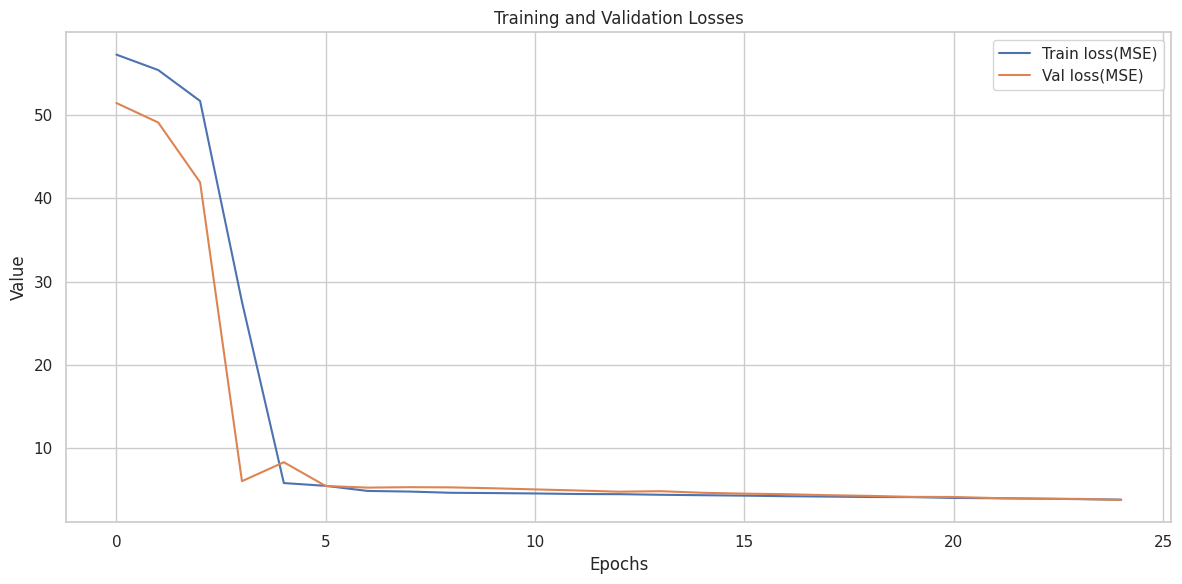

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label=f"Train loss(MSE)")
plt.plot(history.history['val_loss'], label=f"Val loss(MSE)")

plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

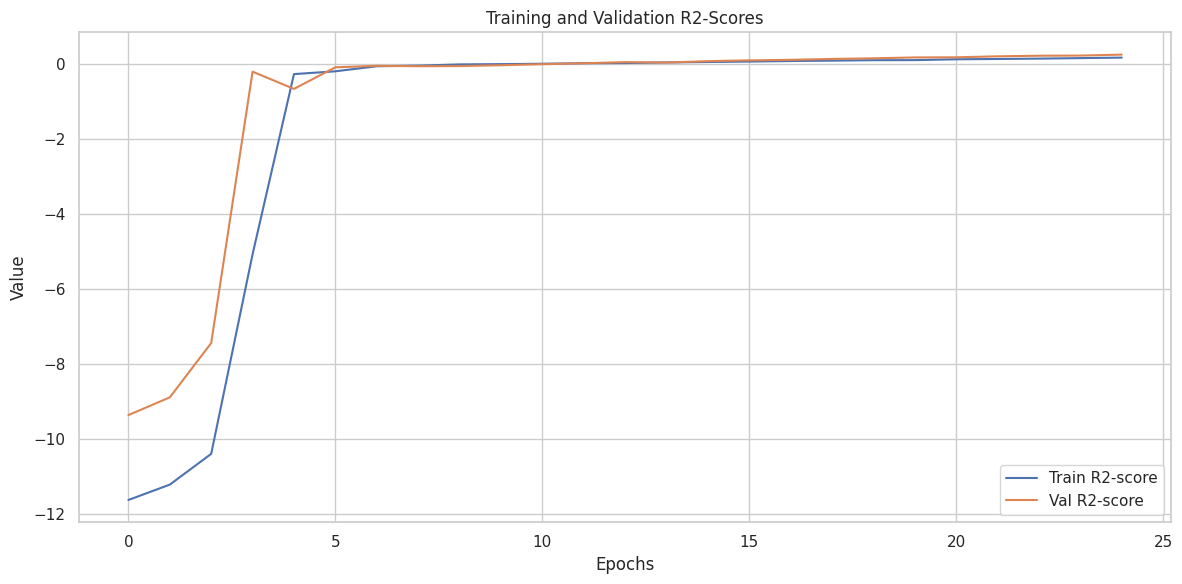

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history["r2_score"], label=f"Train R2-score")
plt.plot(history.history["val_r2_score"], label=f"Val R2-score")

plt.title("Training and Validation R2-Scores")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Below R2-score and MSE are shown on test part of dataset
(for a full dataset R2-score=0.629 and MSE=1.58)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
R²: 0.22704086077237162
MSE: 2.299549057347664
